## CartPole-v0
We will solve CartPole-v0 environment using Reinforce Algorithm, which is a Poliicy Gradient method.

### Reinforce Algorithm

pseudocode:

1. Use the policy $\pi_{\theta}$ to collect $m$ trajectories $\tau^{1}$... $\tau^{n}$.
2. Use the trajectories to estimate the gradient $\nabla_{\theta}U(\theta)$.

     $\nabla_\theta U(\theta): \nabla_\theta U(\theta) \approx \hat{g} := \frac{1}{m}\sum_{i=1}^m \sum_{t=0}^{H} \nabla_\theta \log \pi_\theta(a_t^{(i)}|s_t^{(i)}) R(\tau^{(i)})$
3. Updte the weights of the policy $\theta = \theta + \alpha g$


In [0]:
import gym
gym.logger.set_level(40) 
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### Loss

Now, we are evaluating the action chosen by the policy for a given state by multiplying the log probablity of the action for that state with the cumulative discounted reward for that trajectory $\tau^{(i)}$. 

$\nabla_\theta U(\theta): \nabla_\theta U(\theta) \approx \hat{g} := \frac{1}{m}\sum_{i=1}^m \sum_{t=0}^{H} \nabla_\theta \log \pi_\theta(a_t^{(i)}|s_t^{(i)}) R(\tau^{(i)})$

Hence $\hat{g}$ becomes our loss function and we must backprop from here. 
The ***policy_loss.backward()*** line denotes this fact.

In [0]:

def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    solved = False
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Calculate the discounts
        discounts = [gamma**i for i in range(len(rewards)+1)]
        # Find the cumulative reward for trajectory
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        # Calculat g<hat> 
        for log_prob in saved_log_probs:
            # Note that we have to perform Gradient Ascent, to get the optimal solution
            # Hence we will do gradient descent on -g<hat> , giving us the same solution
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()   # back prop
        optimizer.step()         # gradient descent   
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            solved = True
            break
        
    return scores, solved, i_episode

In [10]:
episodes = []
for i in range(20):
    torch.manual_seed(i)
    policy = Policy().to(device)   # Initialising policy
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)  # Initialising optimizer
    scores, solved, i_episode = reinforce(policy, optimizer)
    if solved:
        episodes.append(i_episode)
    else:
        episodes.append(0)

Episode 100	Average Score: 35.04
Episode 200	Average Score: 55.56
Episode 300	Average Score: 67.36
Episode 400	Average Score: 93.81
Episode 500	Average Score: 159.75
Episode 600	Average Score: 139.53
Episode 700	Average Score: 71.76
Episode 800	Average Score: 135.34
Episode 900	Average Score: 139.74
Episode 1000	Average Score: 131.99
Episode 100	Average Score: 32.28
Episode 200	Average Score: 49.51
Episode 300	Average Score: 62.64
Episode 400	Average Score: 49.66
Episode 500	Average Score: 58.09
Episode 600	Average Score: 139.67
Episode 700	Average Score: 145.74
Episode 800	Average Score: 170.68
Environment solved in 753 episodes!	Average Score: 195.25
Episode 100	Average Score: 25.28
Episode 200	Average Score: 57.27
Episode 300	Average Score: 93.00
Episode 400	Average Score: 59.86
Episode 500	Average Score: 85.10
Episode 600	Average Score: 77.03
Episode 700	Average Score: 97.94
Episode 800	Average Score: 98.75
Episode 900	Average Score: 128.68
Episode 1000	Average Score: 144.56
Episod

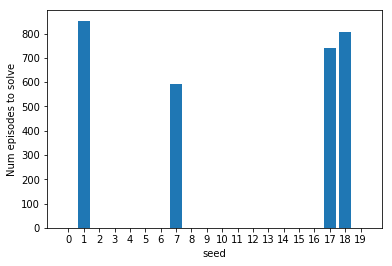

In [12]:
# Plotting the intial seed vs num episodes to solve the env
plt.bar(np.arange(len(episodes)), episodes)
plt.xlabel('seed')
plt.ylabel('Num episodes to solve')
plt.xticks(np.arange(20))
plt.show()

As u can see, with intial seeds as 1,7,17,18 are the only ones, in which the policy could successfully solve the environment within 1000 episodes. Hence the speed at which our policies learn varies greatly with the initial random parameters.